# Preamble

In [1]:
import re
import glob
import os
import pathlib
import healpy as hp
import numpy as np
import xarray as xr
import pandas as pd
import intake
import matplotlib.pyplot as plt
import matplotlib.gridspec as gridspec
from matplotlib.patches import Rectangle
import cartopy.crs as ccrs

# Fetch Data

In [2]:
cat = intake.open_catalog(
    "https://data.nextgems-h2020.eu/catalog.yaml"
)
cat_hera = intake.open_catalog("https://tcodata.mpimet.mpg.de/internal.yaml")
print(f"Experiments in Catalog: {list(cat.keys())}")

Experiments in Catalog: ['ICON', 'IFS', 'FESOM', 'ERA5', 'JRA3Q', 'MERRA2']


In [3]:
# Data
zoom_use = 8

t1 = "2020-03-01"
t2 = "2020-03-30"

t1_AMIP = "1979-03-01"
t2_AMIP = "1979-03-30"

test_data_ngc4008 = (
    cat["ICON"]["ngc4008"](time="P1D", zoom=zoom_use, chunks="auto")
    .to_dask()
    .sel(time=slice(t1, t2))
    .mean(dim="time")
)
test_data_era5 = (
    cat_hera["HERA5"](time="P1D")
    .to_dask()
    .sel(time=slice(t1, t2))
    .mean(dim="time")
)
crs_for_ERA5 = (
    cat["ICON"]["ngc4008"](time="P1D", zoom=7, chunks="auto")
    .to_dask()
)

/work/mh0731/m300868/05_conda_envs/MW_env/easy/lib/python3.12/site-packages/intake_xarray/base.py:21: FutureWarning: The return type of `Dataset.dims` will be changed to return a set of dimension names in future, in order to be more consistent with `DataArray.dims`. To access a mapping from dimension names to lengths, please use `Dataset.sizes`.
  'dims': dict(self._ds.dims),
/work/mh0731/m300868/05_conda_envs/MW_env/easy/lib/python3.12/site-packages/intake_xarray/base.py:21: FutureWarning: The return type of `Dataset.dims` will be changed to return a set of dimension names in future, in order to be more consistent with `DataArray.dims`. To access a mapping from dimension names to lengths, please use `Dataset.sizes`.
  'dims': dict(self._ds.dims),
/work/mh0731/m300868/05_conda_envs/MW_env/easy/lib/python3.12/site-packages/intake_xarray/base.py:21: FutureWarning: The return type of `Dataset.dims` will be changed to return a set of dimension names in future, in order to be more consisten

In [4]:
## Get Lon-Lat Coordinates
def attach_coords(ds, nside, nest_tf):
    lons, lats = hp.pix2ang(nside, ds.cell.values, nest=nest_tf, lonlat=True)
    return ds.assign_coords(
        lat=(("cell",), lats, {"units": "degrees_north"}),
        lon=(("cell",), lons, {"units": "degrees_east"}),
    )
ngc4008 = attach_coords(test_data_ngc4008, test_data_ngc4008.crs.healpix_nside, True)
era5 = test_data_era5.rename({"latitude": "lat", "longitude": "lon"})
crs_for_ERA5 = attach_coords(crs_for_ERA5, crs_for_ERA5.crs.healpix_nside, True)
era5_q_MAR = xr.open_dataset("/work/mh0731/m300868/00_DATA/ERA5/133/E5pl00_1D_1979-03_133.nc").rename({'cells':'cell'}).mean(dim="time")
era5_T_MAR = xr.open_dataset("/work/mh0731/m300868/00_DATA/ERA5/130/E5pl00_1D_1979-03_130.nc").rename({'cells':'cell'}).mean(dim="time")
era5_geoHeight_MAR = xr.open_dataset("/work/mh0731/m300868/00_DATA/ERA5/129/E5pl00_1D_1979-03_129.nc").rename({'cells':'cell'}).mean(dim="time")

In [5]:
## ngcMBE2922
grid_atm = xr.open_dataset(
    "/pool/data/ICON/grids/public/mpim/0025/icon_grid_0025_R02B08_G.nc"
).rename({"clon": "lon", "clat": "lat"})
grid_oce = xr.open_dataset(
    "/pool/data/ICON/grids/public/mpim/0026/icon_grid_0026_R02B08_O.nc"
).rename({"clon": "lon", "clat": "lat"})

grid_atm["lat"] = np.rad2deg(grid_atm.lat)
grid_atm["lon"] = np.rad2deg(grid_atm.lon)
grid_atm["lon"] = (grid_atm["lon"] + 360) % 360

In [6]:
directory = "/work/mh0287/m214002/GIT/icon-mpim-master_dbf6dad5/experiments/mbe2922"
all_files = glob.glob(f"{directory}/*")

pattern_MAR = re.compile(r'mbe2922_atm_3d_P1D_4_\d{4}03(0[1-9]|[12][0-9]|3[01])T.*\.nc')

files_MAR = sorted([file for file in all_files if pattern_MAR.match(os.path.basename(file))])
ngcMBE2922_MAR = (xr.open_mfdataset(files_MAR, combine="by_coords")
                    .rename({"ncells": "cell"})
                    .sel(time=slice('1979-03-01','1979-03-31'))
                    .mean(dim="time")
                   )

In [7]:
directory = "/work/mh0287/m214002/GIT/icon-mpim-master_dbf6dad5/experiments/mbe2922"
all_files = glob.glob(f"{directory}/*")

pattern_MAR = re.compile(r'mbe2922_atm_3d_P1D_1_\d{4}03(0[1-9]|[12][0-9]|3[01])T.*\.nc')

files_MAR = sorted([file for file in all_files if pattern_MAR.match(os.path.basename(file))])
ngcMBE2922_3_MAR = (xr.open_mfdataset(files_MAR, combine="by_coords")
                    .rename({"ncells": "cell"})
                    .sel(time=slice('1979-03-01','1979-03-31'))
                    .mean(dim="time")
                   )

# Process Data

In [8]:
def east_pacific(ds):
    return (ds.lat > BOTTOM) & (ds.lat < TOP) & (ds.lon > ePcf_LEFT) & (ds.lon < ePcf_RIGHT)
    
def west_pacific(ds):
    return (ds.lat > BOTTOM) & (ds.lat < TOP) & (ds.lon > wPcf_LEFT) & (ds.lon < wPcf_RIGHT)

def ocean(ds):
    return ds.ocean_fraction_surface == 1
    
def ocean_native(ds):
    return ds.cell_sea_land_mask == -2

In [9]:
TOP = 10
BOTTOM = -10

wPcf_LEFT  = 150
wPcf_RIGHT = 170
ePcf_LEFT  = 240
ePcf_RIGHT = 260

g_at_equator = 9.78
R_d = 287.05

In [10]:
# ICON Control
ngcMBE2922_3_MAR_wPcf = ngcMBE2922_3_MAR.where(west_pacific(ocean_native(grid_atm)), drop=True)
ngcMBE2922_3_MAR_wPcf_rho = ngcMBE2922_3_MAR_wPcf.rho.mean(dim='cell').compute()

ngcMBE2922_3_MAR_ePcf = ngcMBE2922_3_MAR.where(east_pacific(ocean_native(grid_atm)), drop=True)
ngcMBE2922_3_MAR_ePcf_rho = ngcMBE2922_3_MAR_ePcf.rho.mean(dim='cell').compute()

ngc4008_wPcf = ngc4008.where(west_pacific(ocean(ngc4008)), drop=True)
ngc4008_ePcf = ngc4008.where(east_pacific(ocean(ngc4008)), drop=True)

ngcMBE2922_MAR_wPcf = ngcMBE2922_MAR.where(west_pacific(ocean_native(grid_atm)), drop=True)
ngcMBE2922_MAR_ePcf = ngcMBE2922_MAR.where(east_pacific(ocean_native(grid_atm)), drop=True)

ngcMBE2922_MAR_ePcf_T = ngcMBE2922_MAR_ePcf.ta.mean(dim='cell').compute()

In [11]:
AMIP_1979_MAR_wPcf_height_in_meter = ngc4008_wPcf.zg.mean(dim="cell").sel(level_full=ngcMBE2922_MAR_wPcf.height_2).compute()
AMIP_1979_MAR_ePcf_height_in_meter = ngc4008_ePcf.zg.mean(dim="cell").sel(level_full=ngcMBE2922_MAR_ePcf.height_2).compute()

In [12]:
# ERA5
T_v = era5_T_MAR.T * (1 + 0.61 * era5_q_MAR.Q)

era5_MAR_rho = (era5_geoHeight_MAR.plev / (R_d * T_v)).compute() 
era5_MAR_wPcf_rho = era5_MAR_rho.where(west_pacific(ocean(ngc4008)), drop=True).mean(dim='cell').compute()
era5_MAR_ePcf_rho = era5_MAR_rho.where(east_pacific(ocean(ngc4008)), drop=True).mean(dim='cell').compute()

era5_geoHeight_MAR_ePcf = era5_geoHeight_MAR.where(east_pacific(ocean(ngc4008)), drop=True)
era5_geoHeight_MAR_wPcf = era5_geoHeight_MAR.where(west_pacific(ocean(ngc4008)), drop=True)

era5_MAR_ePcf_height_in_meter = ((era5_geoHeight_MAR_ePcf.Z / g_at_equator)).mean(dim="cell")
era5_MAR_wPcf_height_in_meter = ((era5_geoHeight_MAR_wPcf.Z / g_at_equator)).mean(dim="cell")

ngcMBE2922_MAR_wPcf_T = ngcMBE2922_MAR_wPcf.ta.mean(dim='cell').compute()

era5_MAR_ePcf_T = era5_T_MAR.T.where(east_pacific(ocean(ngc4008)), drop=True).mean(dim='cell').compute()
era5_MAR_wPcf_T = era5_T_MAR.T.where(west_pacific(ocean(ngc4008)), drop=True).mean(dim='cell').compute()
era5_MAR_wPcf_T_with_height = era5_MAR_wPcf_T.assign_coords(height=("plev", era5_MAR_wPcf_height_in_meter.data))

#west_pacific
era5_MAR_wPcf_T_with_height = era5_MAR_wPcf_T.assign_coords(height=("plev", era5_MAR_wPcf_height_in_meter.data))
era5_MAR_wPcf_T_with_height = era5_MAR_wPcf_T_with_height.swap_dims({"plev": "height"})
era5_MAR_wPcf_T_with_height_interp = (
    era5_MAR_wPcf_T_with_height.interp(height=AMIP_1979_MAR_wPcf_height_in_meter, method="linear")
    .drop_vars({'plev','height'})
    .rename({'height_2':'height'})
)

#east_pacific
era5_MAR_ePcf_T_with_height = era5_MAR_ePcf_T.assign_coords(height=("plev", era5_MAR_ePcf_height_in_meter.data))
era5_MAR_ePcf_T_with_height = era5_MAR_ePcf_T_with_height.swap_dims({"plev": "height"})
era5_MAR_ePcf_T_with_height_interp = (
    era5_MAR_ePcf_T_with_height.interp(height=AMIP_1979_MAR_ePcf_height_in_meter, method="linear")
    .drop_vars({'plev','height'})
    .rename({'height_2':'height'})
)

# Plotting

In [13]:
SIZE = 30
plt.rcParams["axes.labelsize"] = SIZE
plt.rcParams["legend.fontsize"] = SIZE
plt.rcParams["xtick.labelsize"] = SIZE
plt.rcParams["ytick.labelsize"] = SIZE
plt.rcParams["font.size"] = SIZE
plt.rcParams['xtick.direction'] = 'in'
plt.rcParams['ytick.direction'] = 'in'
plt.rcParams['xtick.major.size'] = 12
plt.rcParams['ytick.major.size'] = 12
# Enable LaTeX font
plt.rc('text', usetex=False)
plt.rc('font', family='sans-serif')

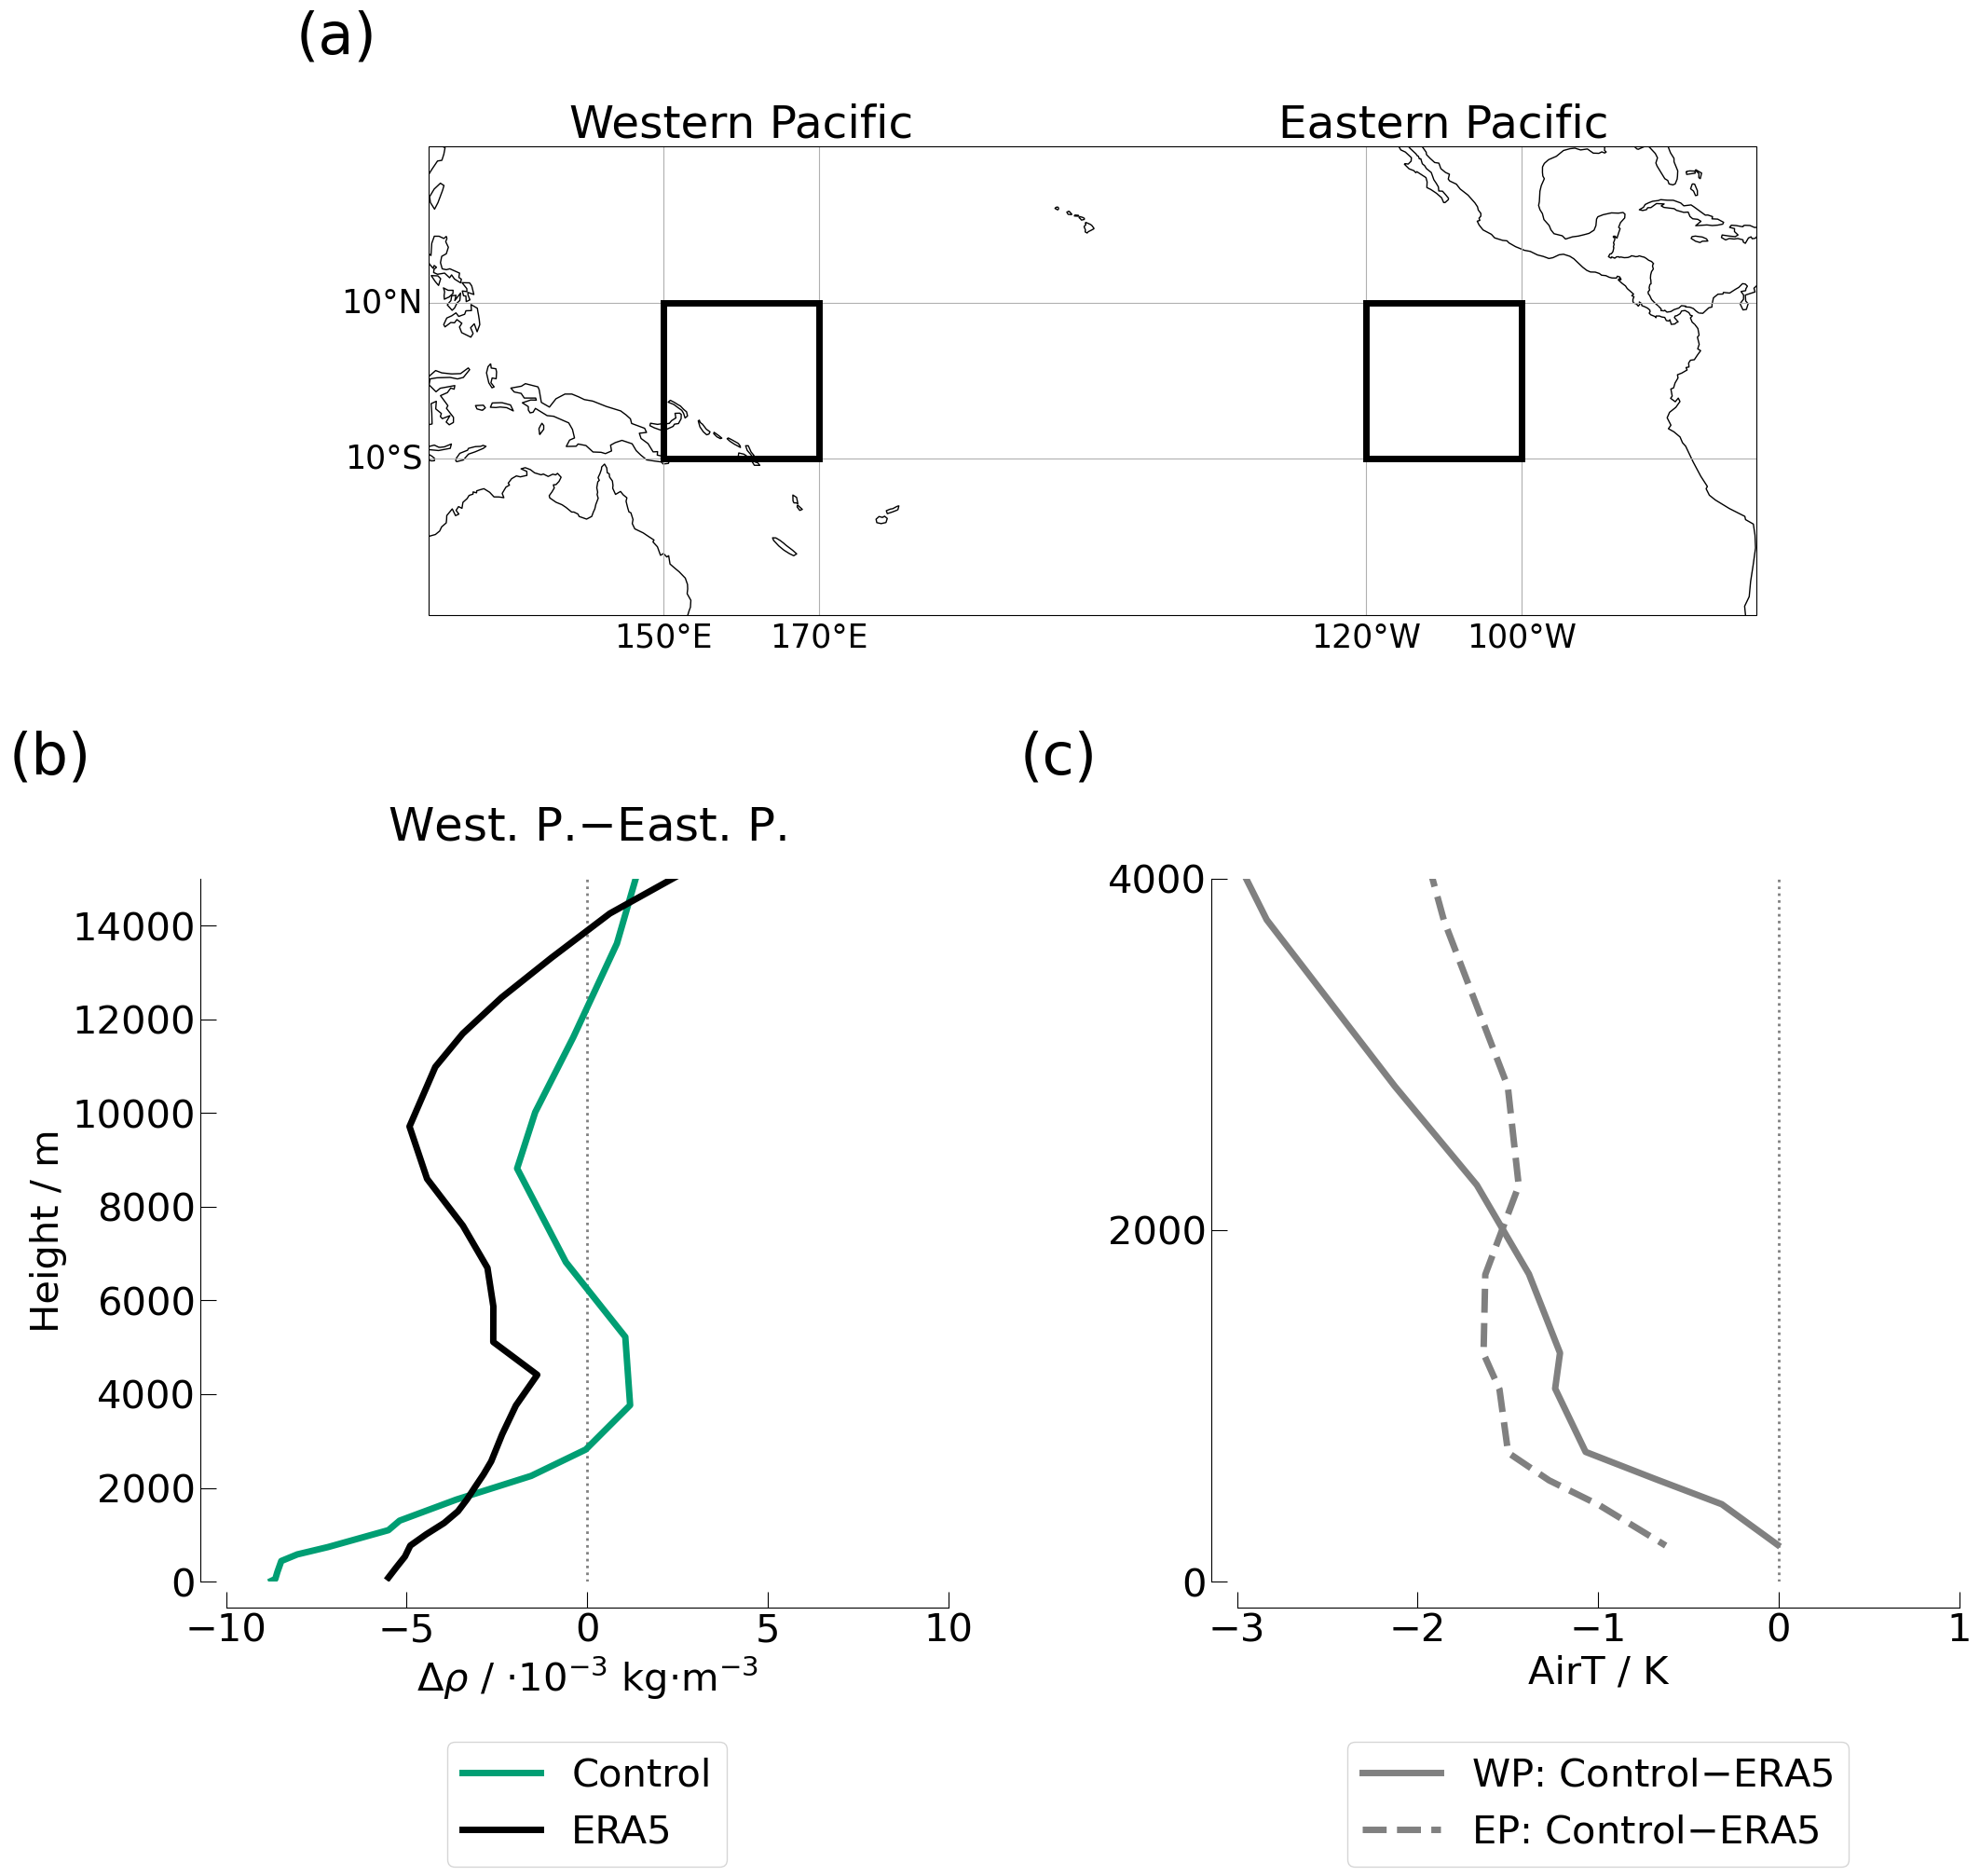

In [14]:
fig = plt.figure(figsize=(24,20), facecolor="w", edgecolor="k")

G = gridspec.GridSpec(2, 2, hspace=0.45, wspace=0.4, height_ratios=[2, 3])

BUCHSTABI = 45

#####################################################################################################################
### Top Plot
#####################################################################################################################

ax1 = plt.subplot(G[0, :], projection=ccrs.PlateCarree(central_longitude=180))
ax1.set_extent([120, 290, -30, 30], crs=ccrs.PlateCarree())

ax1.coastlines()
# Add degree values to x and y ticks
gl = ax1.gridlines(draw_labels=True, xlocs=[150, 170, -120, -100], ylocs=[-10, 10])
gl.xlabel_style = {'size': SIZE-5}  
gl.ylabel_style = {'size': SIZE-5} 
gl.top_labels = False
gl.right_labels = False

ax1.add_patch(Rectangle((-30,-10),20,20,edgecolor='black', facecolor='None', lw=5, alpha=1, zorder=10))
ax1.add_patch(Rectangle((60,-10),20,20,edgecolor='black', facecolor='None', lw=5, alpha=1, zorder=10))

ax1.text(-20, 30, "Western Pacific", ha="center", va="bottom", fontsize=SIZE+5, color="black", zorder=11)
ax1.text(70, 30, "Eastern Pacific", ha="center", va="bottom", fontsize=SIZE+5, color="black", zorder=11)

ax1.text(-0.1, 1.2, '(a)', fontsize=BUCHSTABI, transform=ax1.transAxes)

#####################################################################################################################
### Bottom Left
#####################################################################################################################

XLOW  = -10
XHIGH = 10
YLOW  = 0
YHIGH = 15000

LW=5
NUM_TICKS = 8

ax = plt.subplot(G[1, 0])
ax.axvline(0, color='grey', ls='dotted', lw=2)

ax.plot((ngcMBE2922_3_MAR_wPcf_rho-ngcMBE2922_3_MAR_ePcf_rho)*1000, AMIP_1979_MAR_wPcf_height_in_meter, label='Control', color="#009E73", ls='solid', lw=LW)
ax.plot((era5_MAR_wPcf_rho-era5_MAR_ePcf_rho)*1000, (era5_MAR_ePcf_height_in_meter+era5_MAR_wPcf_height_in_meter)/2, label='ERA5', color='black', lw=LW)

ax.set_title(r"West. P.$-$East. P.", pad=30)
ax.set_ylabel(r"Height / m ")
ax.set_xlabel(r"$\Delta \rho$ / $\cdot10^{-3}$ kg$\cdot$m$^{-3}$")

ax.set_xlim(XLOW, XHIGH)
ax.set_yticks([0,2000,4000,6000,8000,10000,12000,14000])
ax.set_ylim(YLOW, YHIGH)

# Configure the left y-axis
ax.spines[["bottom", "left"]].set_position(("outward", 20))
ax.spines[["top", "right"]].set_visible(False)  # Hide both top and right spines

# Set up the left y-axis with label and tick labels
ax.set_ylabel("Height / m")  # Set the y-axis label on the left
ax.tick_params(axis="y", which="both", labelleft=True)  # Show tick labels on the left y-axis

# Annotate the subplot
ax.text(-0.3, 1.15, '(b)', fontsize=BUCHSTABI, transform=ax.transAxes, color='black')
ax.legend(loc='upper center', bbox_to_anchor=(0.5, -0.2), fancybox=True, shadow=False, ncol=1)


##################################################################################################################
### Bottom Right
##################################################################################################################
XLOW  = -3
XHIGH = 1
NUM_TICKS = 5

YLOW  = 0
YHIGH = 4000

ax = plt.subplot(G[1, 1])
ax.axvline(0, color='grey', ls='dotted', lw=2)

ax.plot(ngcMBE2922_MAR_wPcf_T-era5_MAR_wPcf_T_with_height_interp, AMIP_1979_MAR_wPcf_height_in_meter, label='WP: Control$-$ERA5', color="grey", ls='solid', lw=LW)
ax.plot(ngcMBE2922_MAR_ePcf_T-era5_MAR_ePcf_T_with_height_interp, AMIP_1979_MAR_ePcf_height_in_meter, label=r'EP: Control$-$ERA5', color="grey", ls='dashed', lw=LW)

#ax.set_title(r"West. P.", pad=30)
#ax.set_ylabel(r"Height / m ")
ax.set_xlabel(r"AirT / K")

XTICKS = np.linspace(XLOW, XHIGH, NUM_TICKS)
ax.set_xticks(XTICKS)
ax.set_xlim(XLOW, XHIGH)

YTICKS = np.linspace(YLOW, YHIGH, 3)
ax.set_yticks(YTICKS)
ax.set_ylim(YLOW, YHIGH)

ax.spines[["bottom", "left"]].set_position(("outward", 20))
ax.spines[["right", "top"]].set_visible(False)

ax.text(-0.3, 1.15, '(c)', fontsize=BUCHSTABI, transform=ax.transAxes, color='black')
ax.legend(loc='upper center', bbox_to_anchor=(0.5, -0.2), fancybox=True, shadow=False, ncol=1)

filename = f"figs/fig_06.png"
plt.savefig(filename, facecolor='white', bbox_inches='tight', dpi=200)

plt.show()